In [36]:
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [37]:
dataset = 'conll2003'
supervised_results = {
    'conll2003': [93.72628304430663, 0.4236196517888068 ],
    'ontonotes': [85.40089858116333, 0.47536216945453025],
}
mean, std = supervised_results[dataset]
files = glob.glob(f'/home/rvacareanu/projects_5_22/odinsynth_al/results/221231/{dataset}/token*.jsonl')
data = []
for f in [x for x in files]:
    with open(f) as fin:
        for line in fin:
            data.append(json.loads(line))
# display(df)

groupby_parameters = ['active_learning_iteration', 'annotation_strategy', 'query_strategy_function', 'number_of_al_iterations', 'starting_size_ratio', 'underlying_model', 'epochs', 'number_of_new_examples', 'learning_rate', 'initial_dataset_selection_strategy', 'training_annotation_style', 'dataset_name', 'use_postags_for_selection']
unrolled_data = []
dd1 = defaultdict(int)
dd2 = defaultdict(int)
for x in data:
    for l in x:
        key = tuple([l[x] for x in groupby_parameters])
        dd1[key] += l['number_of_annotated_nonO_tokens']
        dd2[key] += 1
for x in data:
    for l in x:
        key = tuple([l[x] for x in groupby_parameters])
        unrolled_data.append(
            {
                **{k:v for (k, v) in l.items() if k not in ['selected_data_distribution', 'all_args']},
                'f1'                                     : 100 * l['val_metrics']['test_overall_f1'],
                'number_of_annotated_nonO_tokens_smoothed'    : dd1[key]/dd2[key],
                'percentage_of_annotated_nonO_tokens_smoothed': 100 * (dd1[key]/dd2[key]) / l['total_number_of_tokens_available'],
            }
        )

data = unrolled_data

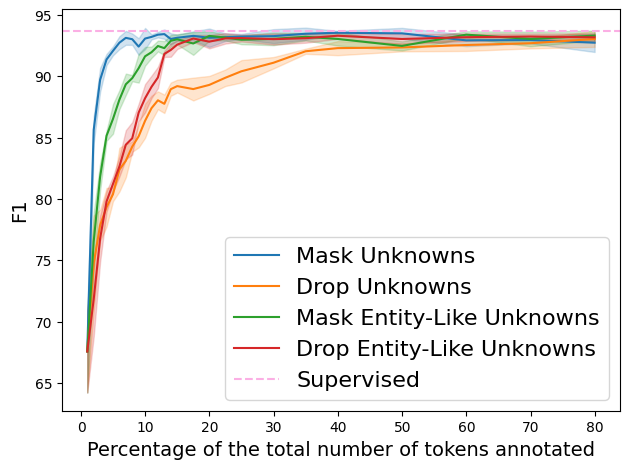

In [38]:

df = pd.DataFrame(data)

# with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
#     print(df[((df['query_strategy_function'] == 'breaking_ties_query') & (df['annotation_strategy'] == 'token_level') & (df['training_annotation_style'] == 'mask_all_unknown'))].groupby(by=['query_strategy_function', 'training_annotation_style', 'percentage_of_annotated_tokens_smoothed']).agg({'f1': ['mean', 'std']}))
#     a()

df = df[df['query_strategy_function'] == 'breaking_ties_query']
df['training_annotation_style'] = df['training_annotation_style'].replace({
    'mask_all_unknown'            : 'Mask Unknowns', 
    'drop_all_unknown'            : 'Drop Unknowns', 
    'mask_entity_looking_unknowns': 'Mask Entity-Like Unknowns', 
    'drop_entity_looking_unknowns': 'Drop Entity-Like Unknowns', 
    'dynamic_window'              : 'Dynamic Window', 
    })
df.rename(columns={'training_annotation_style': 'Data Representation'}, inplace=True)
# display(df[['active_learning_iteration', 'seed', 'annotation_strategy', 'query_strategy_function', 'f1']])
# a()
# sns.lineplot(data=df[df['training_annotation_style'] == 'mask_all_unknown'], x='active_learning_iteration', y='f1', hue='Query Strategy', errorbar='sd', palette=['#0173b2', '#de8f05', '#029e73', '#d55e00'])
sns.color_palette("colorblind")
g = sns.lineplot(data=df, x='percentage_of_annotated_tokens_smoothed', y='f1', hue='Data Representation', hue_order=['Mask Unknowns', 'Drop Unknowns', 'Mask Entity-Like Unknowns', 'Drop Entity-Like Unknowns'], errorbar='sd')#, marker='o')
g.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.axhline(mean, 0, 1, label='Supervised', color='#fbafe4', linestyle='--')
# plt.axhline(y=mean - std, xmin=0, xmax=1, color='#fbafe4', linestyles='--')
# plt.axhline(y=mean + std, xmin=0, xmax=1, color='#fbafe4', linestyles='--')
plt.xlabel("Percentage of the total number of tokens annotated", fontsize=14)
plt.ylabel('F1', fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()

In [39]:
print(sns.color_palette("colorblind").as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
